In [12]:
import sys
import subprocess

print("Python executable:", sys.executable)

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "openpyxl"])


Python executable: C:\Users\josef\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


0

In [13]:
import openai
from openai import OpenAI

print(openai.__version__)




2.8.1


In [14]:
#import pandas as pd
#import matplotlib.pyplot as plt
#from vllm import LLM, SamplingParams
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="not-needed" 
)

MODEL_NAME = "Qwen2-0.5B-Instruct" 

In [15]:
import pandas as pd

df = pd.read_excel("./testdata_MIE.xlsx")
df.to_csv("./testdata_MIE.csv", index=False)

df.head()


,PatientAccountID,MPINumber,AssessmentID,Source,CollectedDT,Finding,FindingName,FindingDataType,Value,AdditionalInformation
0,NaN,P-5xxxxxxxx,NaN,Stammdaten,Jul xx 20xx xx:xxAM,Geburtsdatum,NaN,9,xx/19xx,NaN
1,NaN,P-5xxxxxxxx,NaN,Stammdaten,Jun xx 20xx xx:xxPM,Geschlecht,NaN,1,männlich,NaN
2,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxAM,Diagnose,NaN,1,N18.0,Terminale Niereninsuffizienz
3,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxPM,Diagnose,NaN,1,G63.2*,Diabetische Polyneuropathie
4,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxPM,Diagnose,NaN,1,H36.0*,Retinopathia diabetica


In [16]:
messages = [
    {"role": "user", "content": "Say hello from the Qwen server in one short sentence."}
]

response = client.chat.completions.create(
    model="Qwen/Qwen2-0.5B-Instruct",  
    messages=messages,
    temperature=0.1,
    max_tokens=100,
)

print(response.choices[0].message.content)




Hello from the Qwen server.


In [23]:
from typing import List
import pandas as pd

def build_messages_for_query(df: pd.DataFrame, query: str) -> List[dict]:
    columns = list(df.columns)
    preview = df.head(5).to_string()

    system_content = (
        "You are a precise data analyst working with a pandas DataFrame named df.\n"
        "The DataFrame df is already loaded and available in memory.\n"
        "\n"
        "Forbidden operations:\n"
        "- Do not load any files. No pd.read_csv, no file paths, no placeholders.\n"
        "- Do not recreate df. Do not overwrite df. Do not assign a new DataFrame to df.\n"
        "- Do not introduce variables or filenames that do not exist.\n"
        "\n"
        "Allowed operations:\n"
        "- Use only the existing DataFrame df.\n"
        "- Use only columns that actually exist: "
        f"{columns}\n"
        "- If a required column is missing, raise ValueError.\n"
        "- Use matplotlib.pyplot as plt if a plot is required, and finish with plt.tight_layout() and plt.show().\n"
        "\n"
        "Output format:\n"
        "- Output only pure Python code, with no explanations and no comments.\n"
        "- Do not use markdown or code fences.\n"
    )

    example_user = (
        "Example task: How many patients got diagnosed with N18?"
    )
    
    example_assistant = (
        "required = {'Finding','Value','MPINumber'}\n"
        "missing = required.difference(df.columns)\n"
        "if missing:\n"
        "    raise ValueError(f'Missing required columns: {missing}')\n"
        "mask = (df['Finding']=='Diagnose') & df['Value'].str.contains('N18', na=False)\n"
        "subset = df.loc[mask]\n"
        "print(subset['MPINumber'].nunique())"
    )

    real_user = (
        "Here are the first rows of the dataframe:\n"
        f"{preview}\n\n"
        "Columns:\n"
        f"{columns}\n\n"
        f"Task: {query}"
    )

    return [
        {"role": "system", "content": system_content},
        {"role": "user", "content": example_user},
        {"role": "assistant", "content": example_assistant},
        {"role": "user", "content": real_user},
    ]


def ask_llm(df: pd.DataFrame, query: str) -> str:
    """
    Schickt die Messages an den Qwen-Server und gibt den Code der Antwort zurück.
    Erwartung: reine Python-Code-Antwort, direkt mit exec() ausführbar.
    """
    messages = build_messages_for_query(df, query)

    response = client.chat.completions.create(
        model="Qwen/Qwen2-0.5B-Instruct",
        messages=messages,
        temperature=0.0,  # möglichst deterministisch / wenig Halluzination
        max_tokens=800,
    )

    return response.choices[0].message.content


## RQ - A
How many people got diagnosed with H36 over time?

In [20]:
query = "How many patients got diagnosed with H36? Consider that each patient can have multiple findings."
response_text = ask_llm(df, query)

print("Output:")
print(response_text)



Output:
df['Finding'] = df['Finding'].str.contains('H36', na=False)
df_n18 = df.loc[df['Finding'] == 'Diagnose']
n_patients_n18 = df_n18['MPINumber'].nunique()
print('Number of patients diagnosed with H36:', n_patients_n18)


## RQ - B
How was the age and gender distribution of the disease?

In [21]:
query = "Given the dataframe above, create a pie chart for the Gender distribution."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")


Output:
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataframe
df = pd.read_csv('your_file.csv')

# Get the gender distribution
gender_distribution = df['MPINumber'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()
#########


## RQ - C
What were the five most common secondary diagnoses?

Output:
import matplotlib.pyplot as plt

# Create a DataFrame with the required columns
df = pd.DataFrame({
    'PatientAccountID': [1, 2, 3, 4, 5],
    'MPINumber': [1111111111, 2222222222, 3333333333, 4444444444, 5555555555],
    'AssessmentID': [1111111111, 2222222222, 3333333333, 4444444444, 5555555555],
    'Source': ['Stammdaten', 'Diagnosen', 'Diagnosen', 'Diagnosen', 'Diagnosen'],
    'CollectedDT': ['Jul xx 20xx', 'Jun xx 20xx', 'Jun xx 20xx', 'Jun xx 20xx', 'Jun xx 20xx'],
    'Finding': ['Geburtsdatum', 'Geburtsdatum', 'Geburtsdatum', 'Geburtsdatum', 'Geburtsdatum'],
    'FindingName': ['N18', 'N18', 'N18', 'N18', 'N18'],
    'FindingDataType': ['Terminale Niereninsuffizienz', 'Geburtsdatum', 'Geburtsdatum', 'Geburtsdatum', 'Geburtsdatum'],
    'Value': [9, 9, 9, 9, 9],
    'AdditionalInformation': ['N18.0', 'N18.0', 'N18.0', 'N18.0', 'N18.0']
})

# Plot the five most common secondary diagnoses
plt.figure(figsize=(10, 6))
plt.bar(df['Finding'], df['Value'], color='skyblue')


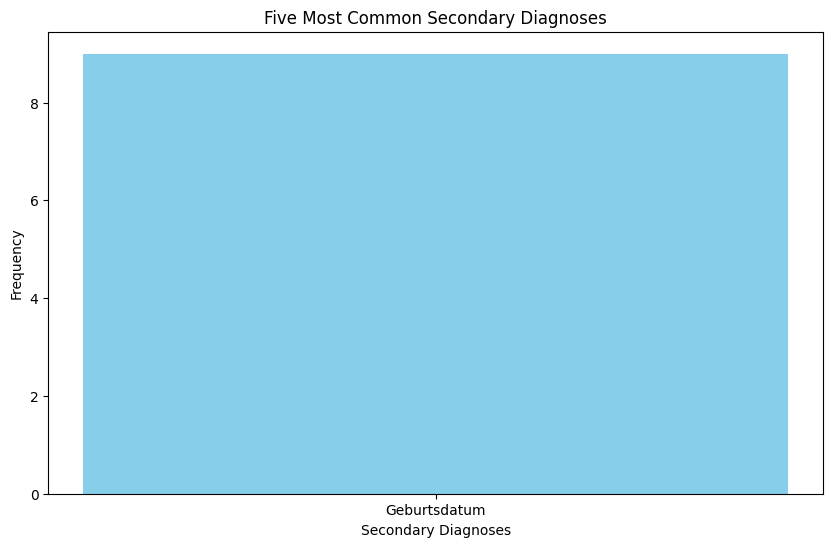

In [24]:
query = "Plot the five most common secondary diagnoses."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)


## RQ - D
How many HBA1C values are there for each patient?

In [ ]:
query = query_template_chat(df, "How many the HBA1C values has each diagnosed patient?", tokenizer)

llm_outputs = llm.generate(query, SamplingParams(temperature=0.1, max_tokens=400))
for i, out in enumerate(llm_outputs):
    print('Output:')
    print(out.outputs[0].text)
    print('#########')